# **Part 4: Preprocessing Temporal Data (Bonus)**

In [ ]:
# Nhập các thư viện cần thiết
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import holidays
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Nhập các thư viện học máy
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
# Đọc dữ liệu cổ phiếu Apple từ tệp CSV
df_aapl = pd.read_csv('../data/stock_market_data/sp500/csv/AAPL.csv')

In [6]:
# Hiển thị 5 dòng đầu tiên của DataFrame
df_aapl.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,12-12-1980,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,15-12-1980,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,16-12-1980,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,17-12-1980,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,18-12-1980,0.118862,0.118862,73449600,0.119420,0.118862,0.092492


### **Các hàm hỗ trợ**

In [7]:
# Hàm này tính các thống kê cơ bản cho một chuỗi dữ liệu, bao gồm trung bình, độ lệch chuẩn, trung vị, độ lệch, độ nhọn, giá trị lớn nhất và nhỏ nhất. Kết quả được trả về dưới dạng một từ điển.
def close_stats(series):
    return {
        "Mean": series.mean(),
        "Std": series.std(),
        "Median": series.median(),
        "Skew": series.skew(),
        "Kutosis": series.kurtosis(),
        "Max": series.max(),
        "Min": series.min()
    }

### **Prasing date and time**

+ Phân tích chuỗi ngày giờ thành các đối tượng ngày giờ thích hợp. 

+ Xử lý các định dạng ngày giờ khác nhau và trích xuất các thành phần (năm, tháng, ngày). 

+ Đặt chỉ mục ngày giờ thích hợp cho chuỗi thời gian.

In [8]:
# Hiển thị thông tin của DataFrame trước khi xử lý
df_aapl.info()

<class 'pandas.DataFrame'>
RangeIndex: 10590 entries, 0 to 10589
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10590 non-null  str    
 1   Low             10590 non-null  float64
 2   Open            10590 non-null  float64
 3   Volume          10590 non-null  int64  
 4   High            10590 non-null  float64
 5   Close           10590 non-null  float64
 6   Adjusted Close  10590 non-null  float64
dtypes: float64(5), int64(1), str(1)
memory usage: 579.3 KB


**Phân tích chuỗi ngày giờ thành các đối tượng ngày giờ thích hợp**

In [9]:
# Chuyển đổi cột 'Date' sang định dạng datetime 
# Sử dụng thư viện pandas với hàm to_datetime và 
# Tham số format để chỉ định định dạng ngày tháng hiện tại trong dữ liệu là 'dd-mm-yyyy' giúp đảm bảo rằng ngày tháng được phân tích chính xác và nhanh hơn
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'], format='%d-%m-%Y')

**Đặt chỉ mục ngày giờ thích hợp cho chuỗi thời gian**

In [10]:
# Sắp xếp DataFrame theo cột 'Date' để dữ liệu tăng dần theo thời gian
# Và đặt cột 'Date' làm chỉ mục của DataFrame để dễ dàng truy cập và thao tác dữ liệu theo thời gian
df_aapl = df_aapl.sort_values('Date').set_index('Date')

**Xử lý các định dạng ngày giờ khác nhau và trích xuất các thành phần (năm, tháng, ngày)**

In [11]:
# Tạo các cột mới 'Year', 'Month', và 'Day' từ chỉ mục ngày tháng
df_aapl['Year'] = df_aapl.index.year
df_aapl['Month'] = df_aapl.index.month
df_aapl['Day'] = df_aapl.index.day

In [12]:
# Hiển thị thông tin của DataFrame sau khi xử lý
df_aapl.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 10590 entries, 1980-12-12 to 2022-12-12
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Low             10590 non-null  float64
 1   Open            10590 non-null  float64
 2   Volume          10590 non-null  int64  
 3   High            10590 non-null  float64
 4   Close           10590 non-null  float64
 5   Adjusted Close  10590 non-null  float64
 6   Year            10590 non-null  int32  
 7   Month           10590 non-null  int32  
 8   Day             10590 non-null  int32  
dtypes: float64(5), int32(3), int64(1)
memory usage: 703.2 KB


### **Handling Time Gaps**

+ Xác định các dấu thời gian bị thiếu. 

+ Áp dụng phương pháp điền tiến hoặc điền lùi. 

+ Sử dụng các kỹ thuật nội suy (tuyến tính, đa thức, spline). 

+ So sánh hiệu quả của chúng.

**Xác định các dấu thời gian bị thiếu**

In [13]:
### Phát hiện các khoang trống trong dữ liệu thời gian

# Tạo một dải ngày đầy đủ từ ngày nhỏ nhất (start) đến ngày lớn nhất (end) trong chỉ mục của df_aapl với tần suất hàng ngày (D)
full_day = pd.date_range(
    start = df_aapl.index.min(),
    end = df_aapl.index.max(),
    freq="D"
)

# Tìm các ngày bị thiếu bằng cách lấy hiệu của full_day và chỉ mục của df_aapl
missing_dates = full_day.difference(df_aapl.index)

# In ra số lượng ngày bị thiếu
print(len(missing_dates))

4751


In [14]:
# Ép DataFrame theo chỉ mục ngày đầy đủ từng ngày => các ngày không có dữ liệu sẽ trở thành NaN
df_aapl = df_aapl.reindex(full_day)

In [15]:
df_aapl.head(20)

,Low,Open,Volume,High,Close,Adjusted Close,Year,Month,Day
1980-12-12,0.128348,0.128348,469033600.0,0.128906,0.128348,0.099874,1980.0,12.0,12.0
1980-12-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.121652,0.122210,175884800.0,0.122210,0.121652,0.094663,1980.0,12.0,15.0
1980-12-16,0.112723,0.113281,105728000.0,0.113281,0.112723,0.087715,1980.0,12.0,16.0
1980-12-17,0.115513,0.115513,86441600.0,0.116071,0.115513,0.089886,1980.0,12.0,17.0
1980-12-18,0.118862,0.118862,73449600.0,0.119420,0.118862,0.092492,1980.0,12.0,18.0
1980-12-19,0.126116,0.126116,48630400.0,0.126674,0.126116,0.098137,1980.0,12.0,19.0
1980-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Áp dụng phương pháp điền tiến và lùi**

In [16]:
# Sử dụng phương pháp forward fill để điền các giá trị NaN bằng giá trị gần nhất trước đó
df_ffill = df_aapl.ffill()

In [17]:
# Kiểm tra lại xem còn ngày nào bị thiếu sau khi điền dữ liệu không
missing_dates = full_day.difference(df_ffill.index)
print(len(missing_dates))

0


In [18]:
# Sử dụng phương pháp backward fill để điền các giá trị NaN bằng giá trị gần nhất sau đó
df_bfill = df_aapl.bfill()

In [19]:
df_bfill.head()

,Low,Open,Volume,High,Close,Adjusted Close,Year,Month,Day
1980-12-12,0.128348,0.128348,469033600.0,0.128906,0.128348,0.099874,1980.0,12.0,12.0
1980-12-13,0.121652,0.122210,175884800.0,0.122210,0.121652,0.094663,1980.0,12.0,15.0
1980-12-14,0.121652,0.122210,175884800.0,0.122210,0.121652,0.094663,1980.0,12.0,15.0
1980-12-15,0.121652,0.122210,175884800.0,0.122210,0.121652,0.094663,1980.0,12.0,15.0
1980-12-16,0.112723,0.113281,105728000.0,0.113281,0.112723,0.087715,1980.0,12.0,16.0


**Áp dụng các kỹ thuật nội suy**

In [20]:
# Sử dụng phương pháp nội suy tuyến tính để điền các giá trị NaN bằng cách nội suy giữa 2 giá trị gần nhất
df_linear = df_aapl.interpolate(method="linear")

# Sử dụng phương pháp nội suy đa thức bậc 2 để điền các giá trị NaN, pandas sẽ fit 1 đường cong đa thức để đi qua các điểm xung quanh rồi
# suy ra giá trị bị thiếu
df_poly = df_aapl.interpolate(method="polynomial", order=2)

# Sử dụng phương pháp nội suy spline bậc 3 để điền các giá trị NaN, pandas sẽ fit 1 đường cong spline để đi qua các điểm xung quanh rồi
# suy ra giá trị bị thiếu
df_spline = df_aapl.interpolate(method="spline", order=3)

In [21]:
df_linear.head()

,Low,Open,Volume,High,Close,Adjusted Close,Year,Month,Day
1980-12-12,0.128348,0.128348,4.690336e+08,0.128906,0.128348,0.099874,1980.0,12.0,12.0
1980-12-13,0.126116,0.126302,3.713173e+08,0.126674,0.126116,0.098137,1980.0,12.0,13.0
1980-12-14,0.123884,0.124256,2.736011e+08,0.124442,0.123884,0.096400,1980.0,12.0,14.0
1980-12-15,0.121652,0.122210,1.758848e+08,0.122210,0.121652,0.094663,1980.0,12.0,15.0
1980-12-16,0.112723,0.113281,1.057280e+08,0.113281,0.112723,0.087715,1980.0,12.0,16.0


In [22]:
df_poly.head()

,Low,Open,Volume,High,Close,Adjusted Close,Year,Month,Day
1980-12-12,0.128348,0.128348,4.690336e+08,0.128906,0.128348,0.099874,1980.0,12.0,12.0
1980-12-13,0.130817,0.131043,3.610218e+08,0.131375,0.130817,0.101795,1980.0,12.0,13.0
1980-12-14,0.128585,0.128997,2.633055e+08,0.129143,0.128585,0.100058,1980.0,12.0,14.0
1980-12-15,0.121652,0.122210,1.758848e+08,0.122210,0.121652,0.094663,1980.0,12.0,15.0
1980-12-16,0.112723,0.113281,1.057280e+08,0.113281,0.112723,0.087715,1980.0,12.0,16.0


In [23]:
df_spline.head()

,Low,Open,Volume,High,Close,Adjusted Close,Year,Month,Day
1980-12-12,0.128348,0.128348,4.690336e+08,0.128906,0.128348,0.099874,1980.000000,12.000000,12.000000
1980-12-13,0.016822,0.016485,3.900694e+08,0.016633,0.016096,0.036178,1980.476834,12.977336,12.991220
1980-12-14,0.016978,0.016645,2.815092e+08,0.016795,0.016256,0.036259,1980.479556,12.913970,14.088221
1980-12-15,0.121652,0.122210,1.758848e+08,0.122210,0.121652,0.094663,1980.000000,12.000000,15.000000
1980-12-16,0.112723,0.113281,1.057280e+08,0.113281,0.112723,0.087715,1980.000000,12.000000,16.000000


**Kết quả so sánh**

In [ ]:
# Trường hợp cột 'Close' loại bỏ các giá trị NaN mà khong sử dụng bất kỳ phương pháp nào để điền dữ liệu, chỉ giữ lại các giá trị không bị thiếu
close = df_aapl['Close']
close_dropna = close.dropna()

In [ ]:
 #Đoạn code này dùng để so sánh thống kê mô tả (descriptive statistics) của dữ liệu giá đóng cửa (Close price) 
# sau khi xử lý missing values bằng nhiều phương pháp nội suy khác nhau. 
# Mục tiêu là xem phương pháp nào giữ được đặc điểm thống kê của dữ liệu tốt nhất.
methods_stats = {
    "Origin": close_stats(close_dropna),
    "Forward Fill": close_stats(df_ffill["Close"]),
    "Backward Fill": close_stats(df_bfill["Close"]),
    "Linear": close_stats(df_linear["Close"]),
    "Polynomial": close_stats(df_poly["Close"]),
    "Spline": close_stats(df_spline["Close"]),
}
stats_table = pd.DataFrame(methods_stats).T  
stats_table = stats_table[["Mean", "Std", "Median", "Skew", "Kutosis", "Max", "Min"]]
print(stats_table)

                    Mean        Std    Median      Skew   Kutosis         Max  \
Origin         16.332137  34.928463  0.484375  2.933522  8.226233  182.009995   
Forward Fill   16.334488  34.908478  0.486607  2.932881  8.223264  182.009995   
Backward Fill  16.345146  34.924378  0.486049  2.931790  8.214898  182.009995   
Linear         16.339817  34.915811  0.485536  2.932179  8.217747  182.009995   
Polynomial     16.336362  34.911129  0.486607  2.933159  8.226551  182.009995   
Spline         16.344886  34.923188  0.459286  2.931924  8.214890  182.009995   

                    Min  
Origin         0.049107  
Forward Fill   0.049107  
Backward Fill  0.049107  
Linear         0.049107  
Polynomial     0.049107  
Spline         0.016096  


In [26]:
# Mô hình dự báo giá cổ phiếu với các phương pháp xử lý dữ liệu thời gian khác nhau dùng để so sánh, đánh giá kết quả sau khi thực hiện
methods = {
    "original": df_aapl,
    "ffill": df_ffill,
    "bfill": df_bfill,
    "linear": df_linear,
    "poly2": df_poly,
    "spline3": df_spline,
}

df = df_aapl.copy()
target_col = "Close"
rows = []


def mape(y_true, y_pred, eps=1e-8):
    """
    Hàm tính Mean Absolute Percentage Error (MAPE) tính theo phần trăm.
    eps tránh chia cho 0 khi y_true là 0 hoặc rất nhỏ.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100


def train_result(methods):
    """
    Hàm tính huấn luyện và đánh giá mô hình hồi quy tuyến tính trên các phương pháp xử lý dữ liệu thời gian khác nhau.
    Trả về DataFrame kết quả với các chỉ số MAE, RMSE, MAPE.
    """
    for name, dfi in methods.items():
        # Chuẩn bị X, y (drop các cột toàn NaN để khỏi lỗi)
        dfi = dfi.dropna(axis=1, how="all")

        if target_col not in dfi.columns:
            rows.append({"method": name, "n_train": 0, "n_test": 0, "MAE": np.nan, "RMSE": np.nan, "R2": np.nan})
            continue

        # Feature = tất cả cột số trừ target
        num_cols = dfi.select_dtypes(include=[np.number]).columns
        feature_cols = [c for c in num_cols if c != target_col]

        # Nếu không đủ feature thì skip
        if len(feature_cols) == 0:
            rows.append({"method": name, "n_train": 0, "n_test": 0, "MAE": np.nan, "RMSE": np.nan, "R2": np.nan})
            continue

        # Lấy các dòng còn y (ground truth)
        data = dfi[feature_cols + [target_col]].dropna(subset=[target_col])

        # Nếu dữ liệu quá ít thì skip
        if len(data) < 30:
            rows.append({"method": name, "n_train": 0, "n_test": 0, "MAE": np.nan, "RMSE": np.nan, "R2": np.nan})
            continue
        
        # Chuẩn bị dữ liệu huấn luyện và kiểm tra
        X = data[feature_cols].to_numpy()
        y = data[target_col].to_numpy()

        # Tách bộ dữ liệu ra: 80% train, 20% test
        split = int(0.8 * len(data))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Huấn luyện mô hình hồi quy tuyến tính
        model = LinearRegression()
        # Fit model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rows.append({
            "method": name,
            "n_train": len(y_train),
            "n_test": len(y_test),
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "MAPE": mape(y_test, y_pred),
        })

    results_df = pd.DataFrame(rows).set_index("method")
    return results_df

results_df = train_result(methods)
print(results_df.to_string(float_format=lambda x: f"{x:,.6f}"))

          n_train  n_test      MAE     RMSE     MAPE
method                                              
original     8472    2118 1.101330 1.593729 1.300840
ffill       12272    3069 1.042712 1.513981 1.238589
bfill       12272    3069 1.037988 1.518880 1.228153
linear      12272    3069 0.907306 1.331345 1.076060
poly2       12272    3069 1.292154 1.855793 1.529688
spline3     12272    3069 0.869962 1.283728 1.060227


### **Extracting time-based features(Trích xuất các đặc trưng liên quan tới thời gian)** 

+ Trích xuất các đặc điểm chu kỳ (ngày trong tuần, tháng, mùa). 

+ Tạo các biến chỉ báo cho các khoảng thời gian đặc biệt (ngày lễ, cuối tuần). 

+ Mã hóa các đặc điểm chu kỳ bằng phép biến đổi sin/cosin.

+ Trích xuất thời gian đã trôi qua kể từ các sự kiện cụ thể.

In [27]:
# Lấy chỉ mục của DataFrame đã được điền giá trị bằng phương pháp forward fill
# df_ffill['Return'] = df_ffill['Close'].pct_change()
idx = df_ffill.index

In [28]:
### Tạo các đặc trưng thời gian bổ sung từ chỉ mục ngày tháng theo dạng số nguyên

# Tạo các cột thời gian bổ sung từ chỉ mục ngày tháng
df_ffill['Day_of_year'] = idx.dayofyear
# Tạo cột quý từ chỉ mục ngày tháng
df_ffill['Quater'] = idx.quarter
# Tạo cột ngày trong tuần từ chỉ mục ngày tháng (0=Thứ Hai, 6=Chủ Nhật)
df_ffill['Day_of_week'] = idx.dayofweek
# Tạo cột tuần trong năm từ chỉ mục ngày tháng
df_ffill['Week_of_year'] = idx.isocalendar().week.astype(int)


**Tạo các biến chỉ báo**

In [29]:
# Tạo cột nhị phân để chỉ ra ngày cuối tuần (Thứ Bảy và Chủ Nhật)
df_ffill['Is_weekend'] = (df_ffill.index.day_of_week >= 5).astype(int)

# Tạo cột nhị phân để chỉ ra ngày lễ ở Mỹ sử dụng thư viện holidays
us_holiday = holidays.USA()
df_ffill['Is_holiday'] = df_ffill.index.to_series().apply(lambda x: int(x in us_holiday))

**Mã hóa các đặc trưng mang tính lặp**

In [ ]:

# Chuyển đổi các tháng trong năm thành dạng tuần hoàn sử dụng hàm sin và cos của numpy
# Tháng (1...12)
m = idx.month
df_ffill['month_sin'] = np.sin(2 * np.pi * m / 12)
df_ffill['month_cos'] = np.cos(2 * np.pi * m / 12)

# Chuyển đổi các ngày trong tuần của mỗi tuần thành dạng tuần hoàn sử dụng hàm sin và cos của numpy
# Ngày trong tuần
dow = idx.dayofweek
df_ffill['dow_sin'] = np.sin(2 * np.pi * dow / 7)
df_ffill['dow_cos'] = np.cos(2 * np.pi * dow / 7)

# Chuyển đổi các quý tuần hoàn sử dụng hàm sin và cos của numpy
# Quý(1..4)
q = idx.quarter
df_ffill['q_sin'] = np.sin(2 * np.pi * q / 4)
df_ffill['q_cos'] = np.cos(2 * np.pi * q / 4)

# Chuyển đổi các ngày trong năm thành dạng tuần hoàn sử dụng hàm sin và cos của numpy
# Ngày trong năm
doy = idx.dayofyear
# is leap_year để xác định xem năm đó có phải là năm nhuận hay không, nếu là năm nhuận thì số ngày trong năm sẽ là 366, ngược lại sẽ là 365. 
# Điều này giúp đảm bảo rằng các đặc trưng tuần hoàn được tính toán chính xác cho cả năm nhuận và không nhuận.
days_in_year = np.where(idx.is_leap_year, 366, 365)
df_ffill['doy_sin'] = np.sin(2 * np.pi * doy/ days_in_year)
df_ffill['doy_cos'] = np.cos(2 * np.pi * doy / days_in_year)

# Chuyển đổi các tuần trong năm thành dạng tuần hoàn sử dụng hàm sin và cos của numpy
# Tuần trong năm
woy = idx.isocalendar().week.astype(int)
df_ffill['woy_sin'] = np.sin(2 * np.pi * woy / 52)
df_ffill['woy_cos'] = np.cos(2 * np.pi * woy / 52)


In [ ]:
# Hiển thị thông tin của DataFrame sau khi tạo các đặc trưng thời gian bổ sung
df_ffill.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 15341 entries, 1980-12-12 to 2022-12-12
Freq: D
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Low             15341 non-null  float64
 1   Open            15341 non-null  float64
 2   Volume          15341 non-null  float64
 3   High            15341 non-null  float64
 4   Close           15341 non-null  float64
 5   Adjusted Close  15341 non-null  float64
 6   Year            15341 non-null  float64
 7   Month           15341 non-null  float64
 8   Day             15341 non-null  float64
 9   Day_of_year     15341 non-null  int32  
 10  Quater          15341 non-null  int32  
 11  Day_of_week     15341 non-null  int32  
 12  Week_of_year    15341 non-null  int64  
 13  Is_weekend      15341 non-null  int64  
 14  Is_holiday      15341 non-null  int64  
 15  month_sin       15341 non-null  float64
 16  month_cos       15341 non-null  float64
 17  dow_sin         1

### **Resampling Time Series Data(Thay đổi mẫu thời gian đầu vào)**

+ Chọn các kỹ thuật phù hợp như lấy mẫu tăng (nội suy), lấy mẫu giảm (tổng hợp) hoặc các hàm tổng hợp khác nhau (trung bình, tổng, lớn nhất, nhỏ nhất). 

+ Sau đó, so sánh ảnh hưởng của các tần số lấy mẫu lại khác nhau đến đặc điểm dữ liệu.

In [32]:
# Áp dụng Dowsampling(giảm tần suất) theo tuần
df_weekly = df_ffill.resample("W").agg({
    "Open": "first", # Giá mở cửa của tuần
    "High": "max", # Giá cao nhất trong tuần
    "Low": "min", # Giá thấp nhất trong tuần
    "Close": "last", # Giá đóng cửa của tuần
    "Adjusted Close": "last", # Giá đóng cửa đã điều chỉnh của tuần
    "Volume": "sum" # Tổng khối lượng giao dịch trong tuần
})

# Áp dụng Dowsampling(giảm tần suất) theo tháng
df_monthly = df_ffill.resample("ME").agg({
    "Open": "first", # Giá mở cửa của tháng
    "High": "max", # Giá cao nhất trong tháng
    "Low": "min", # Giá thấp nhất trong tháng
    "Close": "last", # Giá đóng cửa của tháng
    "Adjusted Close": "last", # Giá đóng cửa đã điều chỉnh của tháng
    "Volume": "sum" # Tổng khối lượng giao dịch trong tháng
})


**So sánh mức độ tác động khi áp dụng resampling**

In [33]:
# Lấy dữ liệu từ ngày 1 tháng 1 năm 2006 đến ngày 1 tháng 1 năm 2007 cho cả dữ liệu hàng ngày, hàng tuần và hàng tháng để so sánh
# Mục đích cho dễ quan sat và đánh giá kết quả sau khi thực hiện
df_daily_2006_2007 = df_ffill.loc["2006-01-01":"2007-01-01"]
df_weekly_2006_2007 = df_weekly.loc["2006-01-01":"2007-01-01"]
df_monthly_2006_2007 = df_monthly.loc["2006-01-01":"2007-01-01"]

In [49]:
print("Số dòng của dữ liệu trước khi xử lý", df_daily_2006_2007.shape)
print("Số dòng của dữ liệu khi áp dụng giảm tần suất theo tuần", df_weekly_2006_2007.shape)
print("Số dòng của dữ liệu khi áp dụng giảm tần suất theo tháng", df_monthly_2006_2007.shape)

Số dòng của dữ liệu trước khi xử lý (366, 25)
Số dòng của dữ liệu khi áp dụng giảm tần suất theo tuần (53, 6)
Số dòng của dữ liệu khi áp dụng giảm tần suất theo tháng (12, 6)


### **Trực quan hóa dữ liệu**

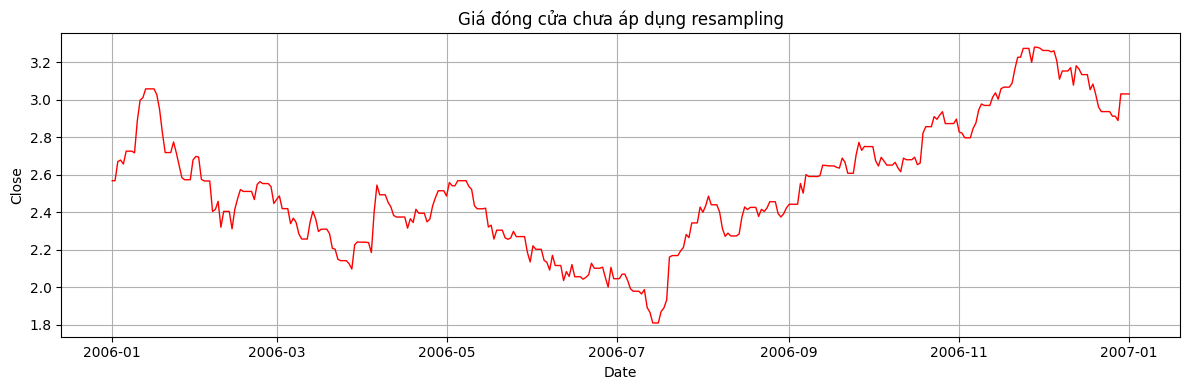

In [ ]:
# Vẽ biểu đồ đường giá đóng cửa của dữ liệu hàng ngày từ ngày 1 tháng 1 năm 2006 đến ngày 1 tháng 1 năm 2007 để quan sát xu hướng giá trong khoảng thời gian này
plt.figure(figsize=(12, 4))
plt.plot(df_daily_2006_2007.index, df_daily_2006_2007["Close"], linewidth=1, color='red')
plt.title("Giá đóng cửa chưa áp dụng resampling")
plt.xlabel("Date")
plt.ylabel("Close")
plt.grid(True)
plt.tight_layout()
plt.show()

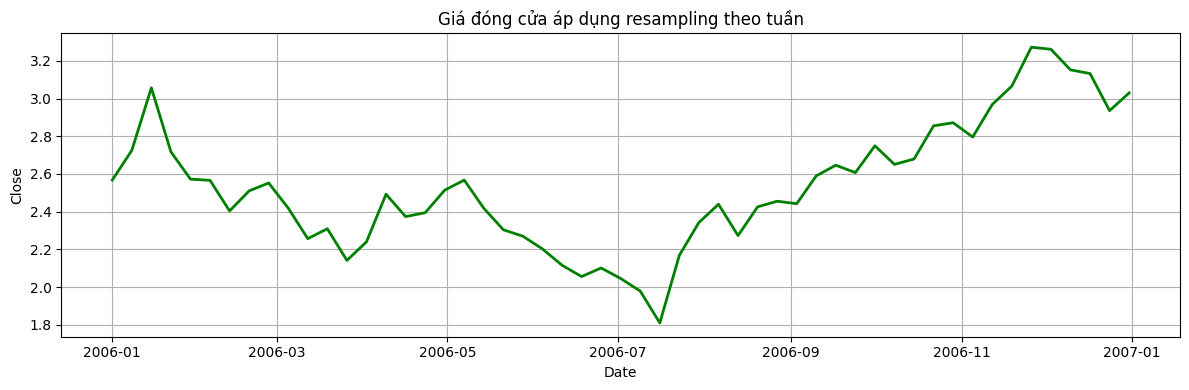

In [ ]:
# Vẽ biểu đồ đường giá đóng cửa của dữ liệu hàng ngày từ ngày 1 tháng 1 năm 2006 đến ngày 1 tháng 1 năm 2007 để quan sát xu hướng giá trong khoảng thời gian này
plt.figure(figsize=(12, 4))
plt.plot(df_weekly_2006_2007.index, df_weekly_2006_2007["Close"], linewidth=2, color='green')
plt.title("Giá đóng cửa áp dụng resampling theo tuần")
plt.xlabel("Date")
plt.ylabel("Close")
plt.grid(True)
plt.tight_layout()
plt.show()

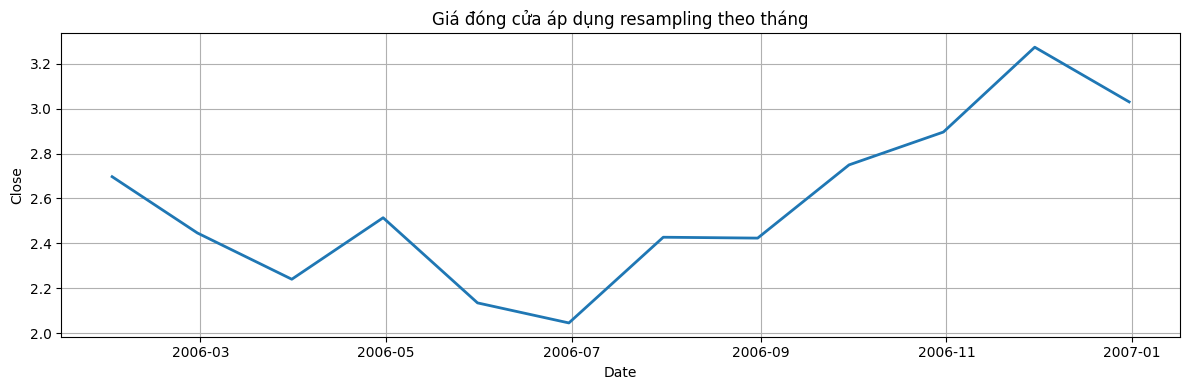

In [ ]:
# Vẽ biểu đồ đường giá đóng cửa của dữ liệu hàng ngày từ ngày 1 tháng 1 năm 2006 đến ngày 1 tháng 1 năm 2007 để quan sát xu hướng giá trong khoảng thời gian này
plt.figure(figsize=(12, 4))
plt.plot(df_monthly_2006_2007.index, df_monthly_2006_2007["Close"], linewidth=2)
plt.title("Giá đóng cửa áp dụng resampling theo tháng")
plt.xlabel("Date")
plt.ylabel("Close")
plt.grid(True)
plt.tight_layout()
plt.show()

**Kết quả so sánh**

In [ ]:
# So sánh thống kê mô tả (descriptive statistics) của dữ liệu giá đóng cửa (Close price) sau khi áp dụng giảm tần suất theo tuần và theo tháng với dữ liệu gốc hàng ngày.
methods_stats = {
    "Daily": close_stats(df_daily_2006_2007["Close"]),
    "Weekly": close_stats(df_weekly_2006_2007["Close"]),
    "Monthly": close_stats(df_monthly_2006_2007["Close"]),
}
stats_table = pd.DataFrame(methods_stats).T
stats_table = stats_table[["Mean", "Std", "Median", "Max", "Min"]]
print(stats_table)

             Mean       Std    Median       Max       Min
Daily    2.534599  0.341418  2.485893  3.278929  1.809643
Weekly   2.537574  0.341373  2.510357  3.272500  1.809643
Monthly  2.572976  0.368653  2.480000  3.273571  2.045357


In [ ]:
# Hiển thị thông tin, số lượng của DataFrame sau khi tạo các đặc trưng thời gian bổ sung
df_weekly.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 2193 entries, 1980-12-14 to 2022-12-18
Freq: W-SUN
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            2193 non-null   float64
 1   High            2193 non-null   float64
 2   Low             2193 non-null   float64
 3   Close           2193 non-null   float64
 4   Adjusted Close  2193 non-null   float64
 5   Volume          2193 non-null   float64
dtypes: float64(6)
memory usage: 184.5 KB


### **Lag Features** 
+ Tạo các đặc trưng lag (t − 1, t − 2, . . . , t − n). 

+ Tạo số liệu thống kê cửa sổ trượt (trung bình động, độ lệch chuẩn trượt).

+ Tạo đặc điểm khác biệt. 

+ Thảo luận về hệ số tự tương quan và lý do lựa chọn các giá trị độ trễ phù hợp.

In [40]:
# Copy DataFrame để tạo các đặc trưng trễ (lag features)
df_lag = df_ffill.copy()

In [41]:
# Dòng t sẽ nhận giá của ngày t-lag vì shift sẽ dịch chuyển giá trị xuống dưới lag dòng
for lag in [1, 5, 10, 22]:
    df_lag[f"lag_{lag}"] = df_lag["Close"].shift(lag)

# Tạo “bộ nhớ quá khứ” cho mỗi dòng dữ liệu.
# Khi train model, mỗi hàng đã có đầy đủ thông tin lịch sử.

In [42]:
# Tạo các đặc trưng trung bình trượt lấy từ n phiên gần nhất tính đến hiện tại
# Giúp mô tả các xu hướng giá trong quá khứ
df_lag["ma_1"] = df_lag["Close"].rolling(1).mean()
df_lag["ma_5"] = df_lag["Close"].rolling(5).mean()
df_lag["ma_10"] = df_lag["Close"].rolling(10).mean()
df_lag["ma_22"] = df_lag["Close"].rolling(22).mean()

In [43]:
# Tạo các đặc trưng độ lệch chuẩn trượt lấy từ n phiên gần nhất tính đến hiện tại
# Giúp dự đoán rủi ro, xác suất biến động, hoặc làm feature cho dự báo
df_lag["vol_1"] = df_lag["Close"].rolling(1).std()
df_lag["vol_5"] = df_lag["Close"].rolling(5).std()
df_lag["vol_10"] = df_lag["Close"].rolling(10).std()
df_lag["vol_22"] = df_lag["Close"].rolling(22).std()


In [44]:
# Tạo các đặc trưng độ lệch giá trượt bằng cách lấy giá hiện tại trừ giá của n phiên trước đó 
# Nếu giá trị âm thì giá đã giảm so với n phiên trước đó, ngược lại nếu giá trị dương thì giá đã tăng
df_lag["diff_1"] = df_lag["Close"].diff(1)
df_lag["diff_5"] = df_lag["Close"].diff(5)
df_lag["diff_10"] = df_lag["Close"].diff(10)
df_lag["diff_22"] = df_lag["Close"].diff(22)


**Kết quả**

In [ ]:
# Tính hệ số tương quan giữa giá đóng cửa hiện tại và giá đóng cửa của các phiên trước đó với các lag khác nhau để xem mức độ liên quan giữa chúng
for lag in [1, 5, 10, 22, 30, 60]:
    corr = df_lag["Close"].corr(df_lag["Close"].shift(lag))
    print(f"Lag {lag}: corr = {corr:.3f}")

Lag 1: corr = 1.000
Lag 5: corr = 0.999
Lag 10: corr = 0.999
Lag 22: corr = 0.997
Lag 30: corr = 0.996
Lag 60: corr = 0.992
